In [1]:
import pandas as pd
import numpy as np

### Desc
The traffic.csv file and the traffic.db SQLite database contain the same web traffic data ("events") from a few different pages ("links") over a period of 7 days including various categorical dimensions about the geographic origin of that traffic as well as a page's content.

Our goal is to understand this traffic better, in particular the volume and distribution of events, and to develop ideas <b>how to increase the links' clickrates</b>. With that in mind, please analyze the data using plain SQL statements as well as the Python Pandas library, providing answers to the following questions:

[SQL + Pandas] <b>How many total pageview events did the links in the provided dataset receive in the full period, how many per day? </b><br>
[SQL + Pandas] <b>What about the other recorded events?</b><br>
[SQL + Pandas] <b>Which countries did the pageviews come from?</b><br>
[SQL + Pandas] <b>What was the overall click rate (clicks/pageviews)?</b><br>
[Pandas] <b>How does the clickrate distribute across different links?</b><br>

In [11]:
ls

README.md             pyproject.toml        traffic.csv
poetry.lock           solution_amina.ipynb  traffic.db


In [12]:
pwd

'/Users/amina/Documents/data-analytics-challenge-2023-main'

In [52]:
import sqlite3
db = 'traffic.db'
con = sqlite3.connect(db)

def select(sql):
    return pd.read_sql(sql, con)

sql = ''' select * from events t '''
select(sql).shape

(226278, 9)

In [409]:
traffic = pd.read_csv('traffic.csv')
traffic.head(3)

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2


In [97]:
traffic.event.unique()

array(['click', 'preview', 'pageview'], dtype=object)

#### How many total pageview events did the links in the provided dataset receive in the full period, how many per day?

In [92]:
# SQL 

sql1 = ''' select count(*) as total
           from events e 
           where event='pageview'      '''

sql2 = ''' select date, count(*) as event_cnt 
          from events e 
          where event='pageview'
          group by 1    '''

total_pageview = select(sql1).total[0]
print('Total pageview events in the full period: ', total_pageview)

print('\nTotal pageview events per day:')
select(sql2)

Total pageview events in the full period:  142015

Total pageview events per day:


,date,event_cnt
0,2021-08-19,22366
1,2021-08-20,21382
2,2021-08-21,21349
3,2021-08-22,20430
4,2021-08-23,18646
5,2021-08-24,18693
6,2021-08-25,19149


In [96]:
# PANDAS

d = traffic[traffic.event=='pageview'].event.count()
print('Total pageview events in the full period: ', d)

print('\nTotal pageview events per day:')
traffic[traffic.event=='pageview'].groupby('date', as_index=False)\
                                  .event.count()\
                        .rename(columns = {'event':'event_cnt'})

Total pageview events in the full period:  142015

Total pageview events per day:


,date,event_cnt
0,2021-08-19,22366
1,2021-08-20,21382
2,2021-08-21,21349
3,2021-08-22,20430
4,2021-08-23,18646
5,2021-08-24,18693
6,2021-08-25,19149


#### What about the other recorded events?

In [108]:
# SQL 

sql1 = ''' select event, count(*) as total_events
           from events e 
           where event<>'pageview'
           group by event   '''

sql2 = ''' 
    select date
         , sum(case when event='click' then 1 else 0 end) as click_events 
         , sum(case when event='preview' then 1 else 0 end) as preview_events 
    from events e 
    where event<>'pageview'
    group by date    '''

tmp1 = select(sql1)
print('''Other totals events, such as 'click' and 'preview', in the full period: ''')
tmp1


Other totals events, such as 'click' and 'preview', in the full period: 


,event,total_events
0,click,55732
1,preview,28531


In [110]:
print('''Other totals events, such as 'click' and 'preview', per day:''')
select(sql2)

Other totals events, such as 'click' and 'preview', per day:


,date,click_events,preview_events
0,2021-08-19,9207,3788
1,2021-08-20,8508,4222
2,2021-08-21,8071,4663
3,2021-08-22,7854,4349
4,2021-08-23,7315,3847
5,2021-08-24,7301,3840
6,2021-08-25,7476,3822


In [134]:
# PANDAS
print('Other total events (click and preview), in the full period:')
tmp1 = traffic[traffic.event!='pageview'].groupby(['event'], as_index=False).linkid.count()\
                                         .rename(columns = {'linkid':'event_cnt'})
tmp1

Other total events (click and preview), in the full period:


,event,event_cnt
0,click,55732
1,preview,28531


In [136]:
print('Other total events (click and preview) per day:')
tmp1 = traffic[traffic.event!='pageview'].groupby(['date', 'event'], as_index=False).linkid.count()\
                                         .rename(columns = {'linkid':'event_cnt'})
tmp1

Other total events (click and preview) per day:


,date,event,event_cnt
0,2021-08-19,click,9207
1,2021-08-19,preview,3788
2,2021-08-20,click,8508
3,2021-08-20,preview,4222
4,2021-08-21,click,8071
5,2021-08-21,preview,4663
6,2021-08-22,click,7854
7,2021-08-22,preview,4349
8,2021-08-23,click,7315
9,2021-08-23,preview,3847


#### Which countries did the pageviews come from?

In [151]:
# SQL 

sql = '''select country, count(*) as event_cnt 
          from events e 
          where event='pageview'
          group by 1    
          order by 2 desc'''

print('Total countries (pageviews come from) = ', select(sql).country.count())
print('\nCountries pageviews come from: ')

select(sql).head(10)

Total countries (pageviews come from) =  211

Countries pageviews come from: 


,country,event_cnt
0,Saudi Arabia,28873
1,India,27286
2,United States,20839
3,France,9674
4,Iraq,4897
5,United Kingdom,3845
6,Pakistan,3212
7,Germany,3141
8,Turkey,2462
9,United Arab Emirates,2335


In [155]:
# PANDAS
print('Countries pageviews come from:')
tmp = traffic[traffic.event=='pageview'].groupby(['country'], as_index=False).event.count()\
                                         .rename(columns = {'event':'event_cnt'})\
                                         .sort_values('event_cnt', ascending=False)
tmp

Countries pageviews come from:


,country,event_cnt
166,Saudi Arabia,28873
88,India,27286
201,United States,20839
65,France,9674
91,Iraq,4897
...,...,...
38,Central African Republic,1
206,Wallis and Futuna,1
155,Principality of Monaco,1
163,Saint Martin,1


#### What was the overall click rate (clicks/pageviews)?

In [198]:
# SQL 

sql = '''select round(
                        count(case when event='click' then event else null end) *1.0 
                        / count(case when event='pageview' then event else null end)
                *100, 2) as click_rate 
          from events e  '''

click_rate = select(sql).click_rate[0]
print('Overall click rate: ', click_rate)

Overall click rate:  39.24


In [199]:
# PANDAS 

clicks = len(df[df['event'] == 'click'])
pageviews = len(df[df['event'] == 'pageview'])

click_rate = clicks / pageviews *100

print("Overall click rate:", np.round(click_rate,2))

Overall click rate: 39.24


#### How does the clickrate distribute across different links?

In [377]:
# PANDAS 

clicks =traffic[traffic.event=='click'].groupby('linkid').size().reset_index()\
                                                                .rename(columns = {0:'click'}).fillna(0)
pageviews =traffic[traffic.event=='pageview'].groupby('linkid').size().reset_index()\
                                                                      .rename(columns = {0:'pageviews'})

click_rates = clicks.merge(pageviews, on='linkid', how='outer')#.fillna(0)
click_rates['click_rate'] = round((click_rates.click /click_rates.pageviews)*100)
click_rates

,linkid,click,pageviews,click_rate
0,00126b32-0c35-507b-981c-02c80d2aa8e7,2.0,2.0,100.0
1,004b9724-abca-5481-b6e9-6148a7ca00a5,1.0,1.0,100.0
2,0063a982-41cd-5629-96d0-e1c4dd72ea11,2.0,3.0,67.0
3,006af6a0-1f0d-4b0c-93bf-756af9071c06,8.0,36.0,22.0
4,00759b81-3f04-4a61-b934-f8fb3185f4a0,3.0,4.0,75.0
...,...,...,...,...
3834,ffaf4f1b-ae3a-5578-bbc2-a55379fed15d,NaN,3.0,NaN
3835,ffc3b266-3736-59d0-a665-8d3f7d7bb3dd,NaN,1.0,NaN
3836,ffe057fd-bc1b-5e12-bca2-7d2d2786facd,NaN,1.0,NaN
3837,ffeafbfb-28da-58a7-9933-d2204848c47c,NaN,1.0,NaN


In [413]:
click_rates['click_rate'].mean()

80.99067909454061

array([[<AxesSubplot:title={'center':'click_rate'}>]], dtype=object)

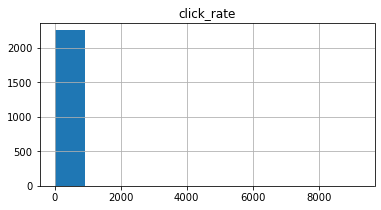

In [379]:
plt.rcParams["figure.figsize"] = (6,3)
click_rates[['linkid','click_rate']].hist()

In [380]:
click_rates.click_rate.describe()

count    2253.000000
mean       80.990679
std       195.805020
min         9.000000
25%        50.000000
50%       100.000000
75%       100.000000
max      9230.000000
Name: click_rate, dtype: float64

array([[<AxesSubplot:title={'center':'click_rate'}>]], dtype=object)

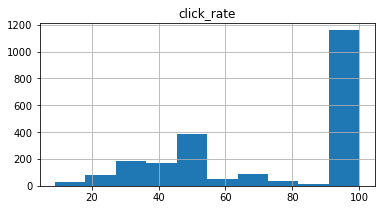

In [355]:
# removing outliers click rate value, distribution 
click_rates[click_rates.click_rate <= click_rates.click_rate.quantile(0.75)].hist()

In [381]:
click_rates.click_rate.value_counts()

100.0     1157
50.0       321
33.0       106
67.0        73
200.0       38
          ... 
73.0         1
86.0         1
61.0         1
167.0        1
9230.0       1
Name: click_rate, Length: 75, dtype: int64

Text(0, 0.5, 'Link ID counts')

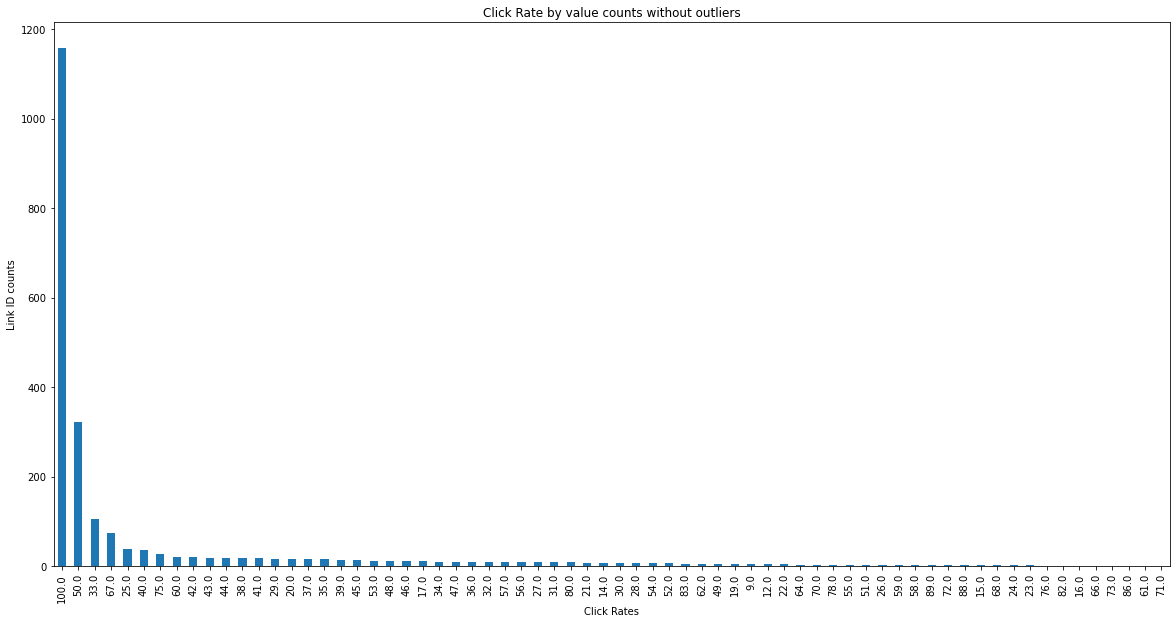

In [384]:
plt.rcParams["figure.figsize"] = (20,10)
click_rates[click_rates.click_rate <= click_rates.click_rate.quantile(0.75)].click_rate.value_counts()\
                                                                            .plot(kind='bar')

plt.title('Click Rate by value counts without outliers')
plt.xlabel('Click Rates')
plt.ylabel('Link ID counts')


### <a href="https://public.tableau.com/app/profile/amina.doszhan/viz/web_traffics_data/mainpage">Dashboard (talbleau)</a>
<br>

### <a href="https://docs.google.com/presentation/d/1CLKQAPqC3AH-1GoVH1H1NVgpVykv8CvklTSNMECC0g0/edit?usp=sharing">Presentaion (google)</a>
